**Date**: 05/19/2022

**Authors**: 

Xiping Gong (Email: xipinggong@umass.edu)

[Jianhan Chen](https://people.chem.umass.edu/jchenlab/) (Email: jianhanc@umass.edu)

# Import packages

In [3]:
# This will import some necessary Python packages (required to run first)
# ---------------
import numpy as np
from matplotlib import pyplot as plt

# Introduction

This module implemented the external force that can be applied into the selected particles or atoms.
Previous CPU-CHARMM program has implemented these functions [1], but they cannot be applied into the GPU calculations directly, so we have to implement them in the OpenMM/CHARMM interface by using the either custom force or plugin module. Given the OpenMM has a CustomExternalForce module, we used the customforce in this case. However, only part of functions have been implemented, for example,

```
pull off
pull force 0.1 xdir 0.0 ydir 0.0 zdir 0.0 select resid 2 .and. type CA end ! one force applied in CA atom of resid 2.
pull list
```

It is noted that the CPU-CHARMM program support the PERIod, EFIEld, TORQue modules, but these are still not supported in the OpenMM/CHARMM program.

**Reference**

[1] https://www.charmm.org/archive/charmm/documentation/by-version/c45b1/cons.html#%20External%20Forces

# Methodology

## The external force and energy

$ E_{ext} = -\sum_{i}{({\bf f}_{i} * {\bf r}_{i})}$,

where the ${\bf f}_{i}$ and ${\bf r}_{i}$ are the force and position of particle $i$.

# Implementations

## OpenMM custom forces

It is easier to use the OpenMM custom external force, please refer to the link [1].
The energy expression could be "-(x*fx + y*fy + z*fz)", and then the it could be shown as follows using a Fortran code,

```
write(formula, '(a)') '-(x*fx+y*fy+z*fz)'
```

After that, we just follows the procedures mentioned in the OpenMM documentation [1], for example, using this energy formula to create a pull force object, and then define the per-partile parameters (such as fx, fy, and fz). The next step should add all particles that will be applied on these forces, and then add this created force into the system of OpenMM.

**Reference**

[1] http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.CustomExternalForce.html

## CHARMM/OpenMM implementations

Two things should be initiallized from the CHARMM input files, the first one is to type the "pull force" commands, for example, 

```
pull off
pull force 1.0 xdir 0.0 ydir 0.0 zdir 1.0 select resid 2 .and. type CA end
pull list
```

"Pull off" will clean all pull forces,
In this step, the input data will be saved in the CPU-CHARMM module. Here, "force 1.0" means the force strength, and "xdir 0.0 ydir 0.0 zdir 1.0" means the direction of force applied, and "select resid 2 .and. type CA end" means what particles will be applied. So, in this case, one CA atom was selected, the external force (fx = force*xdir = 1.0*0.0, fy = force*ydir = 1.0*0.0, and fz = force*zdir = 1.0*1.0) can be applied. 
"pull list" will print out the information, including how many atoms were applied and their fores.

For the implementation, we first check this source code, source/charmm/miscom.F90, which will process these commands.
Initially, we set qpullforce=.true., qpullforce_import_omm=.false., where qpullforce means
the CPU calculations of pull force is on, but this CPU data has not been imported into
omm calculations, until the "omm ..." turns on. The qpullforce_omm=.falase. means the new
pullforce data is not saved into the omm pullforce object.

Then, the omm command should be typed, for example,

```
omm platform CUDA precision mixed deviceid 0
omm on

```

"omm ..." will turn on the omm calculations. This command must be after "pull force ...".
please check source code: source/openmm/omm_ctrl.F90, which will process the omm comands and also the qpullforce_omm will be turned on,

Once the qpullforce_omm=.true., the next step is to import CPU data into the GPU, then we
need to set qpullforce_import_omm=.true. by calling the setup_pullforce subroutine,
please check the source code: source/openmm/omm_bonded.F90, which call import CPU data into OpenMM.

Another thing is that we can update the imported CPU data once another "pull force ..." command coming out,

After that, the energy and dynamic calculations will use the GPU calculations.

# Correctness

To confirm the correctness of implementations, we took kid protein as a test
model, to see whether the GPU calculations can reproduce the CPU calculations. First, the
atomistic forces were calculated from the CPU and CUDA calculations. Then, the NVE imulations were also used to confirm the correctness of protein dynamics.


## CPU vs. GPU forces

The CHARMM input file is "**ener.inp**" showed as below,

```
if @?pdbid eq 0     set pdbid = kid

read  rtf card name top-idpcg-sasa.inp
read para card name hb2.0.inp

read psf card name @pdbid.psf
read coor pdb name @pdbid.pdb

! Nonbonded interactions
! --------------------------
nbond inbfrq -1
NBOND atom switch cdie vdw vswitch -
      cutnb 20.0 ctofnb 18.0 ctonnb 16.0

! pulling force
! --------------------------
pull off
pull force 1.0 xdir 0.0 ydir 0.0 zdir 1.0 select type CA end
!pull list

! energy and forces
! ---------------------
set natom = ?natom
! 1) CPU
energy 
! or omm platform CPU precision mixed deviceid 0
! omm on
! energy
coor force comp
print coor comp sele bynu 1:@natom end
! 2) CUDA
omm platform CUDA precision mixed deviceid 0
omm on
energy
coor force comp
print coor comp sele bynu 1:@natom end

stop
```

Then, runing the following commands, or type "**ener.sh**" shell script,

```
CHARMM=/home/ping/programs/charmm/build/omm_pullforce/charmm

$CHARMM -i ener.inp > ener.out   # charmm is an executable program
grep ' KID  ' ener.out | awk '{print $1, $5, $6, $7}' | head -181 > forces.cpu.dat # natom = 181
grep ' KID  ' ener.out | awk '{print $1, $5, $6, $7}' | tail -181 > forces.gpu.dat
```

/home/ping/pikes_home/work/pullforce/tutorial


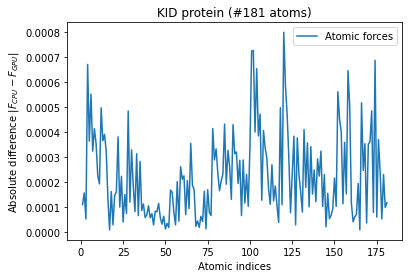

In [6]:
# CPU vs. GPU forces
# ------------------
%cd '/home/ping/pikes_home/work/pullforce/tutorial'
cpuforces = np.loadtxt('forces.cpu.dat')
gpuforces = np.loadtxt('forces.gpu.dat') # CUDA-mixed

inx = cpuforces[:,0]
diff = np.sqrt(np.sum((cpuforces[:,1:4]-gpuforces[:,1:4])**2, axis=1))
plt.plot(inx, diff,label='Atomic forces')
plt.xlabel('Atomic indices')
plt.ylabel('Absolute difference $|F_{CPU} - F_{GPU}|$')
plt.title('KID protein (#181 atoms)')
plt.legend()

**Figure 1**. The correctness of pullforce OpenMM implementations by confirming the protein forces.
The expected absolute difference should be closer to zero for all atomic indices.

## Energy conservation (NVE)

The CHARMM input file is "**nve.inp**" showed as below,

```
if @?pdbid eq 0     set pdbid = kid
if @?openmm eq 0    set openmm = 0

read  rtf card name top-idpcg-sasa.inp
read para card name hb2.0.inp

read psf card name @pdbid.psf
read coor pdb name @pdbid.pdb

! Nonbonded interactions
! --------------------------
nbond inbfrq -1
NBOND atom switch cdie vdw vswitch -
      cutnb 20.0 ctofnb 18.0 ctonnb 16.0

! pulling force
! --------------------------
pull off
pull force 0.1 xdir 0.0 ydir 0.0 zdir 1.0 select type CA end
pull list

! NVE simulation
!-------------------------------------------------------
set nstep = 100000
! 1) CPU
if openmm eq 0 then
   energy
   dynamics leap start timestep 0.002 nstep @nstep -
         inbfrq -1 -
         ilbfrq 1000 nprint 1000

endif

! 2) CUDA
if openmm eq 1 then
   omm platform CUDA precision mixed deviceid 0
   omm on
   energy
   dynamics leap start timestep 0.002 nstep @nstep -
         ilbfrq 1000 nprint 1000
endif
```

Then, runing the following commands, or type "**nve.sh**" shell script,

```
CHARMM=/home/ping/programs/charmm/build/omm_pullforce/charmm
mpirun=/home/ping/programs/openmpi/openmpi-3.0.0/build/bin/mpirun

# running simulations
$CHARMM openmm=1 -i nve.inp > nve.1gpu.out
$CHARMM openmm=0 -i nve.inp > nve.1cpu.out
$mpirun -np 8 $CHARMM openmm=0 -i nve.inp > nve.8cpu.out # mpirun is an executable program

# analysis
grep 'DYNA>' nve.1gpu.out | awk '{print $3, $4}' > nve.1gpu.dat
grep 'DYNA>' nve.1cpu.out | awk '{print $3, $4}' > nve.1cpu.dat
grep 'DYNA>' nve.8cpu.out | awk '{print $3, $4}' > nve.8cpu.dat
```

/home/ping/pikes_home/work/pullforce/tutorial


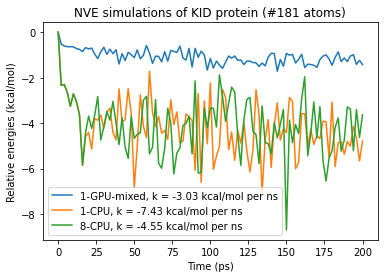

In [14]:
# NVE simulations
# ---------------
# timestep 0.002
%cd '/home/ping/pikes_home/work/pullforce/tutorial'
start = 0
fmt = '{0:.2f}'
nve1gpu = np.loadtxt('nve.1gpu.dat')
k1 = np.polyfit(nve1gpu[start:,0], nve1gpu[start:,1], 1)
nve1cpu = np.loadtxt('nve.1cpu.dat')
k2 = np.polyfit(nve1cpu[start:,0], nve1cpu[start:,1], 1)
nve8cpu = np.loadtxt('nve.8cpu.dat')
k3 = np.polyfit(nve8cpu[start:,0], nve8cpu[start:,1], 1)

plt.plot(nve1gpu[start:,0], nve1gpu[start:,1]-nve1gpu[start,1],label='1-GPU-mixed, k = '+fmt.format(k1[0]*1000)+' kcal/mol per ns')
plt.plot(nve1cpu[start:,0], nve1cpu[start:,1]-nve1cpu[start,1],label='1-CPU, k = '+fmt.format(k2[0]*1000)+' kcal/mol per ns')
plt.plot(nve8cpu[start:,0], nve8cpu[start:,1]-nve8cpu[start,1],label='8-CPU, k = '+fmt.format(k3[0]*1000)+' kcal/mol per ns')
plt.xlabel('Time (ps)')
plt.ylabel('Relative energies (kcal/mol)')
plt.title('NVE simulations of KID protein (#181 atoms)')
plt.legend()

**Figure 2**. NVE simulations of CPU and GPU calculations. The time step was set to 2 fs for the NVE simulations and the mixed precision was used in the GPU calculations.

According to the NVE simulations, the CPU and GPU calculations are almost energy-conserved, but the CPU calculations look a little worse.

# Benchmarking

The perforamnce is determined by the number of atoms or particles you selected.

# Questions

**Q1: What CHARMM version can we use to run pull force GPU calculations?**

It requires version > c47. If you are not sure, then using some examples to test whether it supports, or not.

**Q2: How to run the pull force GPU calculations @pikes workstation?**

Using the following commands before running any GPU simulations or putting them into your ~/.bashrc file.
```
# @pikes, faster node
# -------------------
# GCC
module load gcc/6.1.0
export GCCTK=/cm/local/apps/gcc/6.1.0
export CC=$GCCTK/bin/gcc
export CXX=$GCCTK/bin/g++
# OPENMM
LOCAL=/home/ping/programs/openmm/build/7.5.0
export OPENMM_DIR=$LOCAL
export OPENMM_LIB_PATH=$LOCAL/lib
export OPENMM_INCLUDE_PATH=$LOCAL/include/
export OPENMM_PLUGIN_DIR=$LOCAL/lib/plugins
# CUDA
module load cuda/10.1.243
export CUDATK=/cm/shared/apps/cuda/10.1.243
export PATH=$CUDATK/lib64:$PATH
export PATH=$CUDATK/lib64/stubs:$PATH
export PATH=$CUDATK/bin:$PATH
export OPENMM_CUDA_COMPILER=$CUDATK/bin/nvcc

CHARMM='/home/ping/programs/charmm/build/pullforce/charmm'
mpirun='/home/ping/programs/openmpi/openmpi-3.0.0/build/bin/mpirun'
```

**Q3: How to quickly know I can run the pull force GPU calculations?**

Go to the tutorial folder and run directly the ener.inp CHARMM input file.